Scene-Text Segmentation

In [21]:
# Loading all necessary libraries and modules
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import gridspec

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.np_utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.callbacks import ModelCheckpoint

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix

In [22]:
# Loading ResNet50 wit imagenet weights, include_top means that we loading model without last fully connected layers
model = ResNet50(weights = 'imagenet', include_top = False)

In [121]:
def preprocess_image(image_path, resize):
    orig = cv.imread(image_path)
    image = cv.cvtColor(orig, cv.COLOR_BGR2RGB)
    image = cv.resize(image, resize).reshape(-1, resize[0], resize[1], 3)
    image = preprocess_input(image)
    return orig, image

I want to look how extracted features looks like, so I'll load one images and visualize it:

In [122]:
# Read image
orig, image = preprocess_image('../Datasets/ICDAR13/Train/100.jpg', (224, 224))
features = model.predict(image)

features.shape

(1, 7, 7, 2048)

Now "features" array contains 2048 feature maps wits 7x7 size.

I want to plot random 9 features as example:

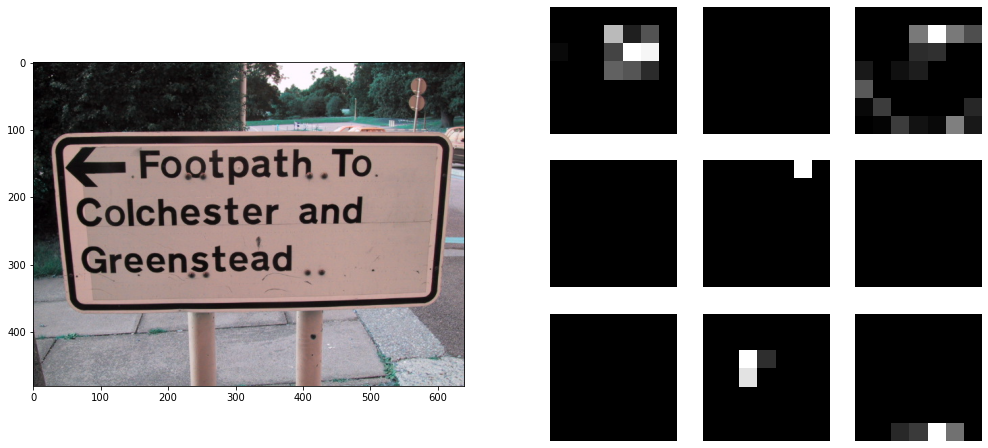

In [123]:
n_features = features.shape[-1]

fig = plt.figure(figsize = (17, 8))
gs = gridspec.GridSpec(1, 2, figure = fig)
sub_gs = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs[1])

ax1 = fig.add_subplot(gs[0])
ax1.imshow(orig)

for i in range(3):
    for j in range(3):
        ax2 = fig.add_subplot(sub_gs[i, j])
        plt.axis('off')        
        plt.imshow(features[0, :, :, np.random.randint(n_features)], cmap = 'gray') 

In [113]:
def read_gt(filepath):
    with open(filepath, 'r') as f:
        data = [txt.split(" ") for txt in f.readlines()]
        final = [each[:-1]+[each[-1].split('"')[1]] for each in data]
    return final

On next step I want to prepare data for training and evaluation.

In [124]:
dataset_path = "..\Datasets\ICDAR13"
sets = ['Train','Val','Test']

annot = {s:dict() for s in sets}

train_X, train_Y = ([], [])
val_X, val_Y = ([], [])
test_X, test_Y = ([], [])

data = [(train_X, train_Y), (val_X, val_Y), (test_X, test_Y)]

for s, d in (zip(sets, data)):
    path_to_images = os.path.join(dataset_path, s)
    for img in os.listdir(path_to_images):
        try:
            if img[-3:] == 'jpg':
                image_path = os.path.join(path_to_images, img)
                orig, image = preprocess_image(image_path, (224, 224)) # (224, 224) = size to be resized
                features = model.predict(image).reshape(100352) # 7*7*2048 = 100352 nodes flattening
                d[0].append(features)

            elif img == 'GT':
                path_to_gt = os.path.join(path_to_images, 'GT')
                gt_files = os.listdir(path_to_gt)
                for files in gt_files:
                    annot[s][files] = read_gt(os.path.join(path_to_gt,files))
        except:
            pass